In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.cnnlstm import CNNLSTMModel
from src.training_utils import *

# Load Segmented Data

In [2]:
# load data splits
data_dir = '../Old_Young_Walking_Data/'
train_data = np.load(data_dir + 'Silder_mixed_train_data.npz')
val_data = np.load(data_dir + 'Silder_mixed_val_data.npz')
test_data = np.load(data_dir + 'Silder_mixed_test_data.npz')
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

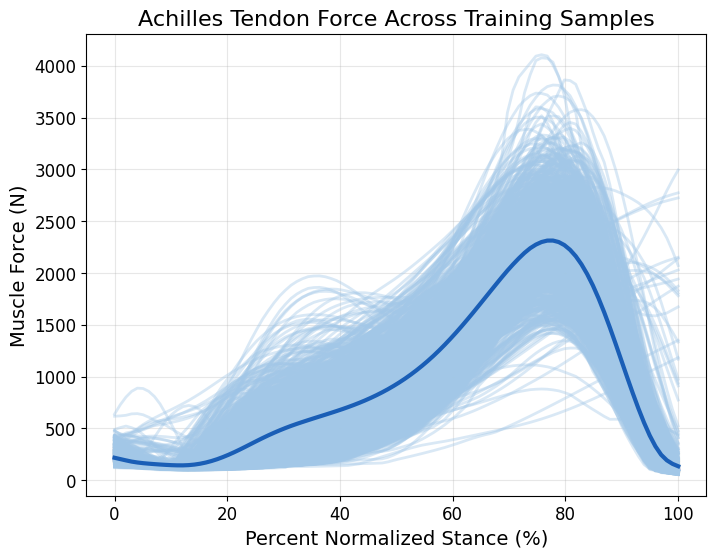

In [3]:
# plot data to double check
plot_achilles_force(y_train)

# Initialize Model

In [4]:
# model parameters
input_size = 3  # grf features (x, y, z)
hidden_size = 64  # hidden size for LSTM (tunable)
num_layers = 2  # number of LSTM layers
output_size = 9  # muscle force features

# create the model
model = CNNLSTMModel(input_size, hidden_size, num_layers, output_size)

In [5]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
# move the model to the device
model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

# Initialize Hyperparameters and data loaders

In [7]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Train Model

In [8]:
best_model, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 174653.3958, Val Loss: 124548.6898
Epoch [10/1000], Train Loss: 168113.7212, Val Loss: 119086.6643
Epoch [20/1000], Train Loss: 162552.0901, Val Loss: 114255.8081
Epoch [30/1000], Train Loss: 157524.4851, Val Loss: 109954.4208
Epoch [40/1000], Train Loss: 152882.7113, Val Loss: 106039.0859
Epoch [50/1000], Train Loss: 148541.4640, Val Loss: 102428.2871
Epoch [60/1000], Train Loss: 144444.1436, Val Loss: 99060.8855
Epoch [70/1000], Train Loss: 140550.2283, Val Loss: 95898.2963
Epoch [80/1000], Train Loss: 136833.2048, Val Loss: 92914.6071
Epoch [90/1000], Train Loss: 133274.7320, Val Loss: 90087.5505
Epoch [100/1000], Train Loss: 129859.7536, Val Loss: 87402.1249
Epoch [110/1000], Train Loss: 126575.5826, Val Loss: 84847.3411
Epoch [120/1000], Train Loss: 123411.8646, Val Loss: 82411.1856
Epoch [130/1000], Train Loss: 120360.1026, Val Loss: 80086.7143
Epoch [140/1000], Train Loss: 117062.2793, Val Loss: 77580.0846
Epoch [150/1000], Train Loss: 113902.6267, Va

# Test Model

In [9]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 17012.5547


# Plot sample prediction

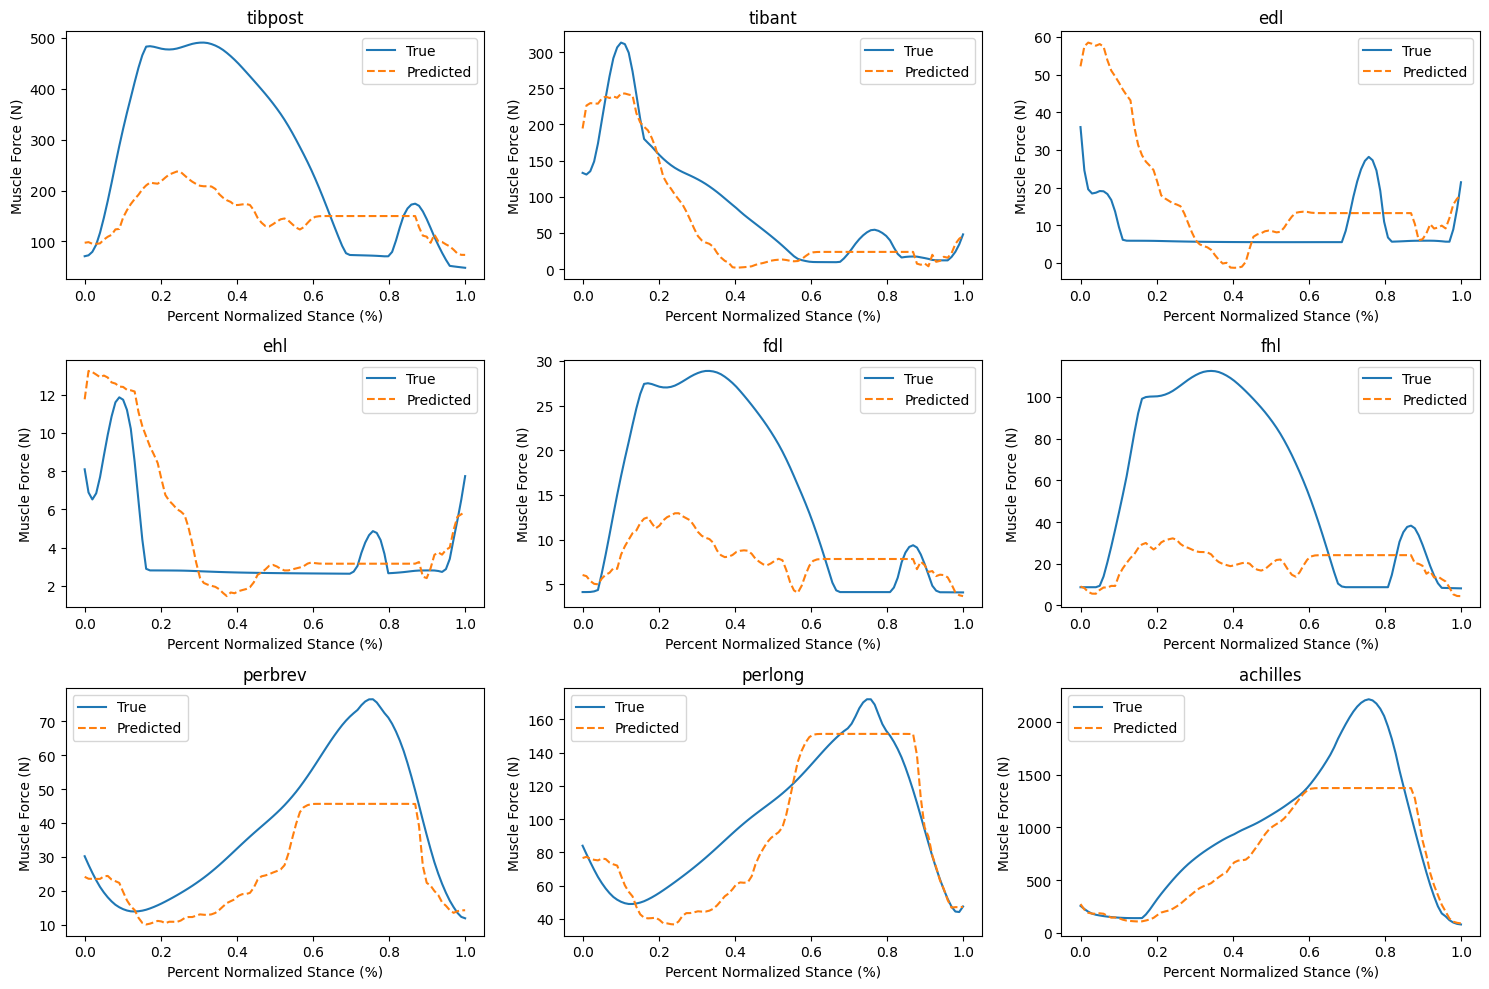

In [10]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)